# iMet Collection 2021 with Lightning ⚡

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [ ]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# copy the dataset to local drive
#! rsync -ah --progress /content/gdrive/Shareddrives/Datasets/Kaggle/iMet/imet-2021-fgvc8.zip imet.zip

In [ ]:
! rm -rf train-1/
! rm -rf test/

# extract dataset to the drive
! unzip /content/gdrive/Shareddrives/Datasets/Kaggle/iMet/imet-2021-fgvc8.zip -d imet-2021-fgvc8 | awk 'BEGIN {ORS=" "} {if(NR%500==0)print "."}'
! ls -l

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . total 12
drwx------ 6 root root 4096 Jun  6 06:09 gdrive
drwxr-xr-x 4 root root 4096 Jun  6 06:27 imet-2021-fgvc8
drwxr-xr-x 1 root root 4096 Jun  1 13:40 sample_data


In [1]:
! pip install -q -U pytorch-lightning torchmetrics
# ! pip install -q https://github.com/Borda/kaggle_plant-pathology/archive/devel.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch
! pip list | grep kaggle

pytorch-lightning             1.3.4              
torch                         1.8.1+cu101        
torchmetrics                  0.3.2              
torchsummary                  1.5.1              
torchtext                     0.9.1              
torchvision                   0.9.1+cu101        
kaggle                        1.5.12             


In [2]:
! nvidia-smi

Sun Jun  6 17:13:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Exploration

Checking what data do we have available...

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_DATASET = "/content/imet-2021-fgvc8/"
pd.read_csv(PATH_DATASET + "train-from-kaggle.csv").head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


Checkout the label mapping , there seems to be some topics note that country as operand inside AND and OR which would be better encoded with just primitives

In [4]:
df_label_map = pd.read_csv(PATH_DATASET + "label_map.csv", index_col="attribute_id")
print(f"len: {len(df_label_map)}")
print(df_label_map.head())

df_label_map["is_OR"] = ['or' in name for name in df_label_map["attribute_name"]]
df_label_map["is_AND"] = ['and' in name for name in df_label_map["attribute_name"]]
df_label_map["topic"] = [name.split("::")[0] if "::" in name else "." for name in df_label_map["attribute_name"]]
topics = set(df_label_map['topic'])

print(f"include OR: {sum(df_label_map['is_OR'])}")
print(f"include AND: {sum(df_label_map['is_AND'])}")
print(f"topics: {topics}")

len: 3474
                    attribute_name
attribute_id                      
0             country::afghanistan
1                country::alamania
2                 country::algeria
3                  country::arabia
4                 country::armenia
include OR: 480
include AND: 409
topics: {'culture', 'medium', 'tags', 'country', 'dimension'}


Also labeling per image seems to be one to many with multiple same topis per image...

len: 142119
                                 id                      attribute_ids
0  000040d66f14ced4cdd18cd95d91800f                       448 2429 782
1  0000ef13e37ef70412166725ec034a8a  2997 3231 2730 3294 3099 2017 784
2  0001eeb4a06e8daa7c6951bcd124c3c7                       2436 1715 23
3  000226398d224de78b191e6db45fd94e                  2997 3433 448 782
4  00029c3b0171158d63b1bbf803a7d750            3465 3322 3170 1553 781
max lbs: 26
{0: 0, 1: 1795, 2: 11941, 3: 33042, 4: 34967, 5: 28014, 6: 16172, 7: 8908, 8: 4094, 9: 1863, 10: 736, 11: 315, 12: 127, 13: 64, 14: 28, 15: 20, 16: 13, 17: 8, 18: 4, 19: 3, 20: 1, 21: 3, 22: 0, 23: 0, 24: 0}


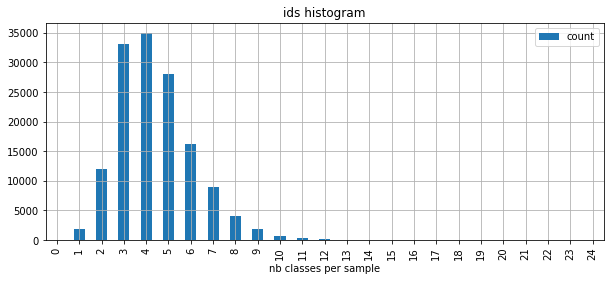

In [24]:
df_train = pd.read_csv(PATH_DATASET + "train-from-kaggle.csv")
print(f"len: {len(df_train)}")
print(df_train.head())

df_train['nb_classes'] = [len(lbs.split(" ")) for lbs in df_train['attribute_ids']]
lb_hist = dict(zip(range(25), np.bincount(df_train['nb_classes'])))
df_hist = pd.DataFrame([dict(lb=lb, count=count) for lb, count in lb_hist.items()]).set_index("lb")

print(f"max lbs: {max(df_train['nb_classes'])}")
df_hist.plot(kind="bar", grid=True, title="labels combination histogram", xlabel='nb classes per sample', figsize=(10, 4))
print(lb_hist)

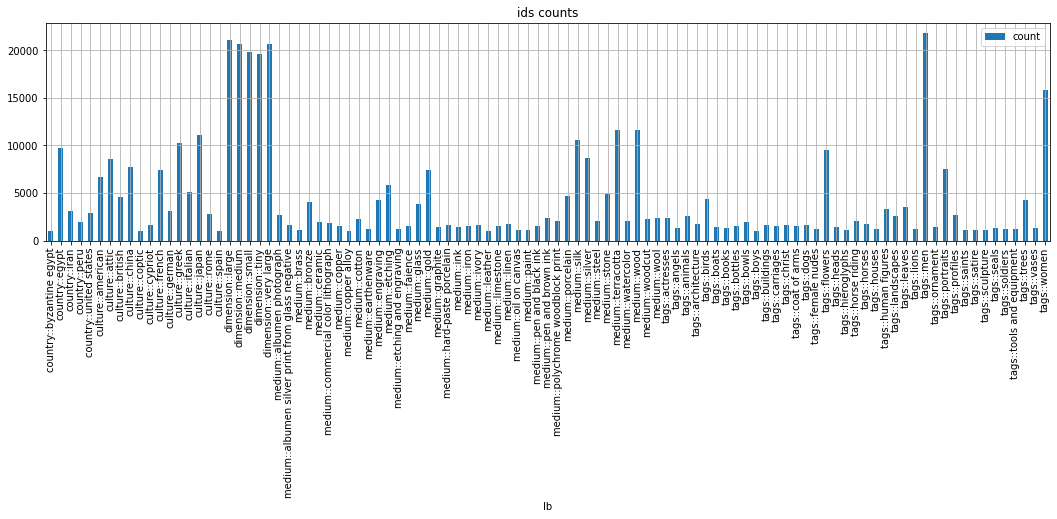

In [26]:
import itertools

label_map = dict(zip(df_label_map.index, df_label_map['attribute_name']))
COUNT_THR = 1000

labels_all = list(itertools.chain(*[[int(lb) for lb in lbs.split(" ")] for lbs in df_train['attribute_ids']]))
lb_hist = dict(zip(range(max(labels_all) + 1), np.bincount(labels_all)))
df_hist = pd.DataFrame([dict(lb=label_map[lb], count=count) for lb, count in lb_hist.items() if count > COUNT_THR]).set_index("lb")

ax = df_hist.plot(kind="bar", grid=True, title="ids counts", figsize=(18, 4))
# print(lb_hist)

## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations. We define the sample pair as:
- RGB image
- one-hot lable encding

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

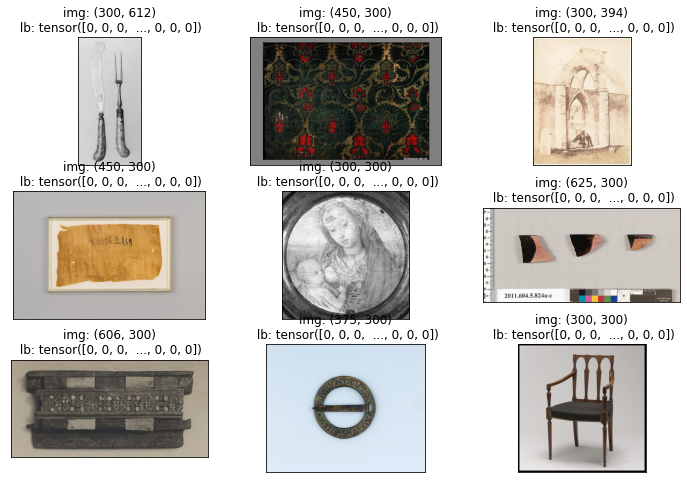

In [6]:
import glob
import itertools
import logging
import multiprocessing as mproc
import os
from typing import Dict, List, Optional, Sequence, Tuple, Type, Union

import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from joblib import Parallel, delayed


ImageFile.LOAD_TRUNCATED_IMAGES = True


def get_nb_pixels(img_path: str):
    try:
        img = Image.open(img_path)
        return np.prod(img.size)
    except Exception:
        return 0


class IMetDataset(Dataset):
    """The ful dataset with one-hot encoding for multi-label case."""
    IMAGE_SIZE_LIMIT = 1000
    COL_LABELS = 'attribute_ids'
    COL_IMAGES = 'id'

    def __init__(
        self,
        df_data: Union[str, pd.DataFrame] = 'train-from-kaggle.csv',
        path_img_dir: str = 'train-1/train-1',
        transforms=None,
        mode: str = 'train',
        split: float = 0.8,
        uq_labels: Tuple[str] = None,
        random_state=42,
        check_imgs: bool = True,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode
        self._img_names = None
        self._raw_labels = None

        # set or load the config table
        if isinstance(df_data, pd.DataFrame):
            self.data = df_data
        elif isinstance(df_data, str):
            assert os.path.isfile(df_data), f"missing file: {df_data}"
            self.data = pd.read_csv(df_data)
        else:
            raise ValueError(f'unrecognised input for DataFrame/CSV: {df_data}')

        # take over existing table or load from file
        if uq_labels:
            self.labels_unique = tuple(uq_labels)
        else:
            labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in self.raw_labels]))
            self.labels_unique = tuple(sorted(set(labels_all)))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # filter/drop too small images
        if check_imgs:
            with Parallel(n_jobs=mproc.cpu_count()) as parallel:
                self.data['pixels'] = parallel(delayed(get_nb_pixels)(os.path.join(self.path_img_dir, im)) for im in self.img_names)
            nb_small_imgs = sum(self.data['pixels'] < self.IMAGE_SIZE_LIMIT)
            if nb_small_imgs:
                logging.warning(f"found and dropped {nb_small_imgs} too small or invalid images :/")
            self.data = self.data[self.data['pixels'] >= self.IMAGE_SIZE_LIMIT]
        # shuffle data
        self.data = self.data.sample(frac=1, random_state=random_state).reset_index(drop=True)

        # split dataset
        assert 0.0 <= split <= 1.0, f"split {split} is out of range"
        frac = int(split * len(self.data))
        self.data = self.data[:frac] if mode == 'train' else self.data[frac:]
        # need to reset after another split since it cached
        self._img_names = None
        self._raw_labels = None
        self.labels = self._prepare_labels()

    @property
    def img_names(self):
        if not self._img_names:
            self._img_names = [f"{n}.png" if '.' not in n else n for n in self.data[self.COL_IMAGES]]
        return self._img_names

    @property
    def raw_labels(self):
        if not self._raw_labels:
            self._raw_labels = list(self.data[self.COL_LABELS])
        return self._raw_labels

    def _prepare_labels(self) -> list:
        return [torch.tensor(self.to_onehot_encoding(lb)) if lb else None for lb in self.raw_labels]

    def to_onehot_encoding(self, labels: str) -> tuple:
        # processed with encoding
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_name = self.img_names[idx]
        img_path = os.path.join(self.path_img_dir, img_name)
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        # todo: find some faster way, do conversion only if needed; im.mode not in ("L", "RGB")
        img = Image.open(img_path).convert('RGB')

        # augmentation
        if self.transforms:
            img = self.transforms(img)
                
        # in case of predictions, return image name as label
        label = label if label is not None else img_name
        return img, label

    def __len__(self) -> int:
        return len(self.data)


dataset = IMetDataset(
    df_data=PATH_DATASET + "train-from-kaggle.csv",
    path_img_dir=PATH_DATASET + "train-1/train-1",
)

# quick view
fig = plt.figure(figsize=(12, 8))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"img: {img.size}\n lb: {lb}")

In [7]:
from pytorch_lightning import LightningDataModule


class IMetDM(LightningDataModule):

    IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg')

    def __init__(
        self,
        base_path: str,
        path_csv: str = 'train-from-kaggle.csv',
        batch_size: int = 128,
        num_workers: int = None,
        train_transforms=None,
        valid_transforms=None,
        split: float = 0.8,
    ):
        super().__init__()
        # path configurations
        assert os.path.isdir(base_path), f"missing folder: {base_path}"
        self.train_dir = os.path.join(base_path, 'train-1/train-1')
        self.test_dir = os.path.join(base_path, 'test/test')

        if not os.path.isfile(path_csv):
            path_csv = os.path.join(base_path, path_csv)
        assert os.path.isfile(path_csv), f"missing table: {path_csv}"
        self.path_csv = path_csv

        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

        # other configs
        self.batch_size = batch_size
        self.split = split
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.labels_unique: Sequence = ...
        self.lut_label: Dict = ...
        self.label_histogram: Tensor = ...

        # need to be filled in setup()
        self.train_dataset = None
        self.valid_dataset = None
        self.test_table = []
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return max(self.train_dataset.num_classes, self.valid_dataset.num_classes)

    @staticmethod
    def onehot_mapping(
        onehot: Tensor,
        lut_label: Dict[int, str],
        thr: float = 0.5,
        label_required: bool = True,
    ) -> Union[str, List[str]]:
        """Convert Model outputs to string labels

        Args:
            onehot: one-hot encoding
            lut_label: look-up-table with labels
            thr: threshold for label binarization
            label_required: if it is required to return any label and no label is above `thr`, use argmax
        """
        assert lut_label
        # on case it is not one hot encoding but single label
        if onehot.nelement() == 1:
            return lut_label[onehot[0]]
        labels = [lut_label[i] for i, s in enumerate(onehot) if s >= thr]
        # in case no reached threshold then take max
        if not labels and label_required:
            idx = torch.argmax(onehot).item()
            labels = [lut_label[idx]]
        return sorted(labels)

    def onehot_to_labels(self, onehot: Tensor, thr: float = 0.5, label_required: bool = True) -> Union[str, List[str]]:
        """Convert Model outputs to string labels

        Args:
            onehot: one-hot encoding
            thr: threshold for label binarization
            label_required: if it is required to return any label and no label is above `thr`, use argmax
        """
        return self.onehot_mapping(onehot, self.lut_label, thr=thr, label_required=label_required)

    def setup(self, *_, **__) -> None:
        """Prepare datasets"""
        pbar = tqdm.tqdm(total=4)
        assert os.path.isdir(self.train_dir), f"missing folder: {self.train_dir}"
        ds = IMetDataset(self.path_csv, self.train_dir, mode='train', split=1.0)
        self.labels_unique = ds.labels_unique
        self.lut_label = dict(enumerate(self.labels_unique))
        pbar.update()
        
        ds_defaults = dict(
            df_data=ds.data,
            path_img_dir=self.train_dir,
            split=self.split,
            uq_labels=self.labels_unique,
            check_imgs=False,
        )
        self.train_dataset = IMetDataset(**ds_defaults, mode='train', transforms=self.train_transforms)
        logging.info(f"training dataset: {len(self.train_dataset)}")
        pbar.update()
        self.valid_dataset = IMetDataset(**ds_defaults, mode='valid', transforms=self.valid_transforms)
        logging.info(f"validation dataset: {len(self.valid_dataset)}")
        pbar.update()

        if not os.path.isdir(self.test_dir):
            return
        ls_images = glob.glob(os.path.join(self.test_dir, '*.*'))
        ls_images = [os.path.basename(p) for p in ls_images if os.path.splitext(p)[-1] in self.IMAGE_EXTENSIONS]
        self.test_table = [{'id': n, 'attribute_ids': ''} for n in ls_images]
        self.test_dataset = IMetDataset(
            df_data=pd.DataFrame(self.test_table),
            path_img_dir=self.test_dir,
            split=0,
            uq_labels=self.labels_unique,
            mode='test',
            transforms=self.valid_transforms
        )
        logging.info(f"test dataset: {len(self.test_dataset)}")
        pbar.update()

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self) -> Optional[DataLoader]:
        if self.test_dataset:
            return DataLoader(
                self.test_dataset,
                batch_size=self.batch_size,
                num_workers=self.num_workers,
                shuffle=False,
            )
        logging.warning('no testing images found')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 4/4 [02:10<00:00, 36.90s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: [2, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 10, 13, 7, 1, 5, 1, 1, 3, 1, 1, 4, 1, 1, 14, 2, 1, 1, 15, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 1, 1, 2, 1, 3, 1, 4, 2, 1, 1, 2, 1, 6, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 6, 1, 1, 1, 2, 2, 1, 4, 1, 1, 1, 1, 1, 1, 23, 14, 4, 3, 7, 1, 14, 1, 1, 1, 1, 2, 1, 1, 2, 1, 6, 1, 1, 14, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 14, 3, 2, 1, 2, 1, 1, 3, 1, 2, 2, 6, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 6, 2, 3, 6, 2, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 4, 2, 1, 3, 5, 1, 1, 2, 1, 3, 1, 1, 1, 7, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 2, 1, 4, 1, 3, 1, 1, 2, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 4, 1, 6, 3, 1, 3, 1, 1, 1, 36, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 16, 1, 2, 3, 1, 2, 2, 3, 32, 2, 4, 16, 1, 1, 1, 1, 1, 10, 1, 19, 5, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,

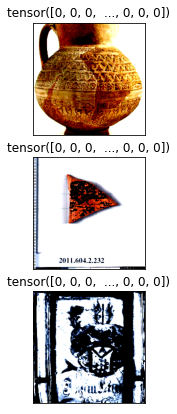

In [8]:
from PIL import Image
from torchvision import transforms as T

#: default training augmentation
TORCHVISION_TRAIN_TRANSFORM = T.Compose([
    T.Resize(size=512, interpolation=Image.BILINEAR),
    T.RandomRotation(degrees=30),
    T.RandomPerspective(distortion_scale=0.2),
    T.RandomResizedCrop(size=224),
    T.RandomHorizontalFlip(p=0.5),
    # T.RandomVerticalFlip(p=0.5),
    # T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #T.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD),  # custom
])
#: default validation augmentation
TORCHVISION_VALID_TRANSFORM = T.Compose([
    T.Resize(size=256, interpolation=Image.BILINEAR),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #T.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD),  # custom
])

dm = IMetDM(
    base_path=PATH_DATASET,
    batch_size=228,
    train_transforms=TORCHVISION_TRAIN_TRANSFORM,
    valid_transforms=TORCHVISION_VALID_TRANSFORM,
    # num_workers=0,
)
dm.setup()

# Quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.val_dataloader():
    batch_lb_sum = torch.sum(lbs, axis=0).numpy()
    print(f'batch labels: {list(batch_lb_sum[batch_lb_sum > 0])}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some stanrd CNN models taken from torch vision. Then we define Ligthning module including training and validation step and configure optimizer/schedular.

In [27]:
from typing import Optional

import torch
import torchmetrics
import torchvision
from pytorch_lightning import LightningModule
from torch import nn, Tensor
from torch.nn import functional as F


class LitResnet(nn.Module):

    def __init__(self, arch: str, pretrained: bool = True, num_classes: int = 6):
        super().__init__()
        self.arch = arch
        self.num_classes = num_classes
        self.model = torchvision.models.__dict__[arch](pretrained=pretrained)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

class LitMet(LightningModule):
    """
    This model is meant and tested to be used together with ...
    """

    def __init__(self, model, lr: float = 1e-4, augmentations: Optional[nn.Module] = None):
        super().__init__()
        self.model = model
        self.arch = self.model.arch
        self.num_classes = self.model.num_classes
        self.train_accuracy = torchmetrics.Accuracy()
        _metrics_extra_args = dict(num_classes=self.num_classes, multilabel=True, average='weighted')
        self.train_precision = torchmetrics.Precision(**_metrics_extra_args)
        self.train_f1_score = torchmetrics.F1(**_metrics_extra_args)
        self.val_accuracy = torchmetrics.Accuracy()
        self.val_precision = torchmetrics.Precision(**_metrics_extra_args)
        self.val_f1_score = torchmetrics.F1(**_metrics_extra_args)
        self.learning_rate = lr
        self.aug = augmentations

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(self.model(x))

    def compute_loss(self, y_hat: Tensor, y: Tensor):
        return F.binary_cross_entropy_with_logits(y_hat, y.to(y_hat.dtype))

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.aug:
            x = self.aug(x)  # => batched augmentations
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy(y_hat, y), prog_bar=False)
        self.log("train_prec", self.train_precision(y_hat, y), prog_bar=False)
        self.log("train_f1", self.train_f1_score(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy(y_hat, y), prog_bar=True)
        self.log("valid_prec", self.val_precision(y_hat, y), prog_bar=True)
        self.log("valid_f1", self.val_f1_score(y_hat, y), prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]


# see: https://pytorch.org/vision/stable/models.html
net = LitResnet(arch='resnet50', num_classes=dm.num_classes)
# print(net)

model = LitMet(model=net, lr=5e-4)

## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [28]:
import pytorch_lightning as pl
print(pl.__version__)

logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid_f1',
    save_top_k=1,
    save_last=True,
    # save_weights_only=True,
    filename='checkpoint/{epoch:02d}-{valid_acc:.4f}-{valid_f1:.4f}',
    # verbose=False,
    mode='max',
)

# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    # accelerator='ddp_spawn',
    callbacks=[ckpt, swa],
    logger=logger,
    max_epochs=3,
    precision=16,
    #overfit_batches=5,
    auto_lr_find=True,
    accumulate_grad_batches=24,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
    weights_summary='top',
)

# ==============================

# lr_find_kwargs = dict(min_lr=1e-5, max_lr=1e-2, num_training=25)
# trainer.tune(model, datamodule=dm, lr_find_kwargs=lr_find_kwargs)
# print(f"LR: {model.learning_rate}")

# ==============================

trainer.fit(model=model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


1.3.4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | model           | LitResnet | 30.6 M
1 | train_accuracy  | Accuracy  | 0     
2 | train_precision | Precision | 0     
3 | train_f1_score  | F1        | 0     
4 | val_accuracy    | Accuracy  | 0     
5 | val_precision   | Precision | 0     
6 | val_f1_score    | F1        | 0     
----------------------------------------------
30.6 M    Trainable params
0         Non-trainable params
30.6 M    Total params
122.480   Total estimated model params size (MB)


Swapping scheduler <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7f601d2ed210> for <torch.optim.swa_utils.SWALR object at 0x7f601dc34710>


Quick visualization of the training process...

   valid_loss  valid_acc  valid_prec  ...  train_acc  train_prec  train_f1
0    0.720017   0.998723         0.0  ...        NaN         NaN       NaN
1    0.694812   0.998723         0.0  ...        NaN         NaN       NaN
2    0.693425   0.998723         0.0  ...        NaN         NaN       NaN
3    0.693240   0.998723         0.0  ...        NaN         NaN       NaN
4    0.693187   0.998723         0.0  ...        NaN         NaN       NaN

[5 rows x 10 columns]


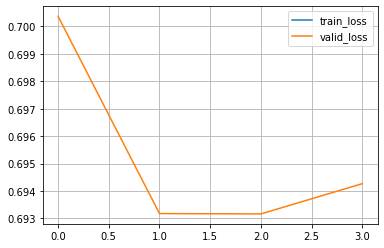

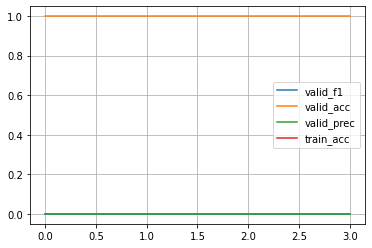

In [29]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'valid_loss']].plot(grid=True, legend=True)
df_metrics[['valid_f1', 'valid_acc', 'valid_prec', 'train_acc']].plot(grid=True, legend=True)

## Predictions

In [ ]:
preds = []
dm.batch_size = 128
model.cuda().eval()

pbar = tqdm.tqdm(total=len(dm.test_dataset))
for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        onehots = model(imgs.cuda()).cpu()
    # print(np.round(onehots.detach().numpy(), decimals=2))
    for oh, name in zip(onehots, names):
        lbs = dm.onehot_to_labels(oh)
        preds.append({'id': os.path.splitext(name)[0], 'attribute_ids': " ".join(lbs)})
    # break
    pbar.update(len(names))

df_preds = pd.DataFrame(preds)
print(df_preds.head())
print(len(df_preds))
df_preds.to_csv('submission.csv', index=False)

In [31]:
# df_preds = pd.DataFrame(preds)
df_base = pd.DataFrame(dm.test_table)
df_base['id'] = [os.path.splitext(n)[0] for n in df_base['id']]

_preds = list(df_preds)
missing = [{'id': n, 'attribute_ids': ""} for n in df_base['id'] if n not in _preds]
print(f"found missing: {len(missing)}")
df_result = pd.merge(df_preds, pd.DataFrame(missing), how="outer")
df_result.drop_duplicates(subset=['id'], inplace=True)
print(df_result.head())
print(len(df_result))
df_result.to_csv('submission2.csv', index=False)

found missing: 53111
                                 id attribute_ids
0  60aeccd10eadfff8b177ebfcd500ec32          2140
1  d8e16ea64b0b10d43146e579badd7e51          1550
2  551575f20ae13cd923a03ed470b52dc0          2140
3  8d19eb8b3b51608f3dfc73f30f3504a9          2500
4  4fdf2b57cbee3998c7ad6ca2eaac511d          1550
53111


### Save with plain PyTorch

In [32]:
torch.save(model.model, f'fgvc8_{net.arch}.pt')

net2 = torch.load(f'fgvc8_{net.arch}.pt')
model2 = LitMet(model=net2)

In [33]:
preds = []
model2.cpu().eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        onehots = model2(imgs).cpu()
    print(np.round(onehots.detach().numpy(), decimals=2))
    break


100%|██████████| 53110/53110 [26:49<00:00, 39.18it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
